# Задача №3.
Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.
Цель лабораторной работы: изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.


Задание:
Выберите набор данных (датасет) для решения задачи классификации или регрессии.
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
Сравните метрики качества исходной и оптимальной моделей.

## Текстовое описание набора данных 

В качестве набора данных мы будем использовать набор данных по предсказанию поступления в аспирантуру

Данные доступны по ссылке https://www.kaggle.com/datasets/mohansacharya/graduate-admissions
Эта задача является актуальной для людей, собирающихся поступать в аспирантуру, и которым необходимо оценить свои шансы.

Датасет состоит из 1 файла:
- Admission_Predict.csv

Файл содержит следующие колонки:
- GRE Score  - баллы за экзамен GRE для поступления в магистратуру/аспирантуру.
- TOEFL Score - баллы за экзамен TOEFL по английскому.
- University Rating - рейтинг университета.
- SOP - мотивация соискателя
- LOR - сила рекомендательного письма.
- CGPA - средний балл аттестата.
- Research - наличие опыта в исследовательских работах.
- Chance of Admit - шанс приема.
- University - название университета

## Добавляем библиотеки

In [1]:
%pip install -q seaborn
%pip install -q scipy

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score

## Изучение данных

In [4]:
data = pd.read_csv('Admission_Predict_Ver1.1.csv')
data.head()


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,country,country codes
0,1,337,118,4,4.5,4.5,9.65,1,0.92,Great Britain,1
1,2,324,107,4,4.0,4.5,8.87,1,0.76,India,2
2,3,316,104,3,3.0,3.5,8.00,1,0.72,India,2
3,4,322,110,3,3.5,2.5,8.67,1,0.80,France,0
4,5,314,103,2,2.0,3.0,8.21,0,0.65,India,2


In [5]:
data.shape

(500, 11)

In [6]:
data.keys()

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit ', 'country',
       'country codes'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
 9   country            500 non-null    object 
 10  country codes      500 non-null    int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 41.1+ KB


In [8]:
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,country codes
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174,1.182000
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114,0.928763
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000,0.000000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000,0.000000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000,2.000000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000,2.000000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000,2.000000


<ipython-input-9-87748a28a882>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.2f')


<AxesSubplot:>

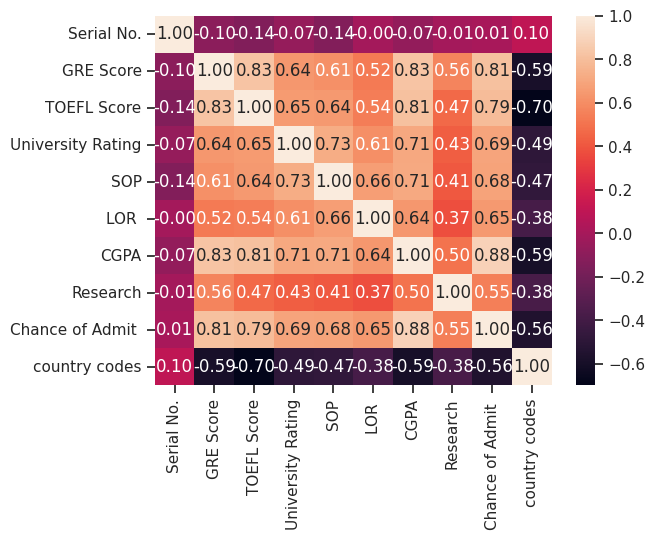

In [9]:
sns.heatmap(data.corr(), annot=True, fmt='.2f')

# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

In [10]:
try:
 data = data.drop(columns=['country codes', 'country'])
except:
    pass

In [11]:
data['Chance of Admit '] = (data['Chance of Admit '] * 100).astype(int)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    int32  
dtypes: float64(3), int32(1), int64(5)
memory usage: 33.3 KB


In [13]:
# Здесь сохраняем результаты машинного обучевния
results = pd.DataFrame()

# Счетчтик для нумерация моеделй
count_model = 0

In [14]:
# Признак и цель
X = data[['GRE Score', 'TOEFL Score', 'University Rating', 'Research']]
y = data['Chance of Admit ']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200, 4), (300, 4), (200,), (300,))

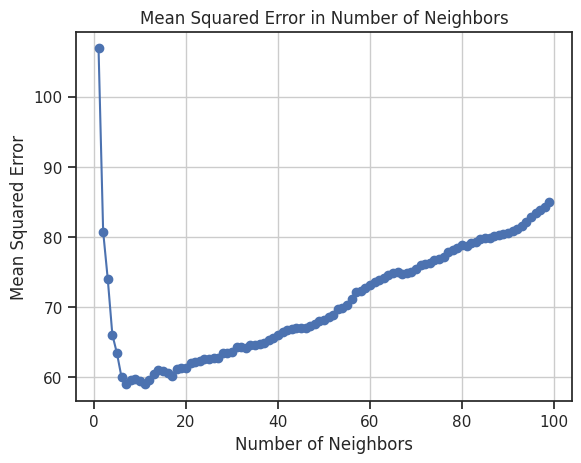

In [16]:
mse_values = []

# Проходим по различным значениям параметра n_neighbors
for i in range(1, 100):
    knn_model = KNeighborsRegressor(n_neighbors=i, leaf_size = 50)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Построение графика
plt.plot(range(1, 100), mse_values, marker='o', linestyle='-')
plt.title('Mean Squared Error in Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

In [18]:
# Определение гиперпараметров для GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 101)}

# Создание модели K ближайших соседей
knn_model = KNeighborsRegressor()

mse_scorer = make_scorer(mean_squared_error)

# Использование двух различных стратегий кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=kf, scoring=mse_scorer)
grid_search.fit(X_train, y_train)

# Результаты GridSearchCV
def find_min_mean_test_score(scores = grid_search.cv_results_):
    
    # Extract the 'mean_test_score' values from the input dictionary
    mean_test_scores = scores['mean_test_score']
    
    # Find the index of the minimum value
    min_index = np.argmin(mean_test_scores)
    
    # Find the minimum value
    min_value = mean_test_scores[min_index]
    return [min_index, min_value]

min_index, min_value = find_min_mean_test_score(grid_search.cv_results_)

print("Best parameters (GridSearchCV):", min_index)
print("Best score (GridSearchCV):", min_value)

# RandomizedSearchCV
random_search = RandomizedSearchCV(knn_model, param_distributions=param_grid, n_iter=20, cv=skf, scoring=mse_scorer, random_state=42)
random_search.fit(X_train, y_train)

min_index, min_value = find_min_mean_test_score(random_search.cv_results_)
# Результаты RandomizedSearchCV
print("Best parameters (RandomizedSearchCV):", min_index)
print("Best MSE (RandomizedSearchCV):", min_value)


Best parameters (GridSearchCV): 16
Best score (GridSearchCV): 59.42702422145328


/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (RandomizedSearchCV): 6
Best MSE (RandomizedSearchCV): 60.48348771266541
